# POR HACER
- Hacer estado desado, o confirmacion de estado final
- Revisar funciones y documentar
- Importante **Animar** 

## Estado

El estado es una matriz de adyacencia, que indicara cuales fragmentos de pista estan conectados, por ejemplo si la matriz es de $2 \times 2 $, es decir tenemos solo dos piezas de carretera: 
$$
\begin{pmatrix}
1 & 0 \\
0 & 1 
\end{pmatrix}
$$
No nos interesa la diagonal de la matriz, porque las piezas no pueden estar conectadas hacia si mismos.

Nuestra matriz sera de $ 32 \times 32 $ porque tenemos 32 fragmentos  de piezas 

## Estado inicial

In [55]:
# importamos las librererias necesarias y configuramos manim, libreria necesaria para animaciones
import numpy as np
import pandas as pd

import random
from manim import *
import networkx as nx
import matplotlib.pyplot as plt
config.media_width = "100%"

# Declaramos las contantes, las cantidades de piezas de cada tipo
RECTAS = 12
CURVAS = 16
DISECCION_1 = 2
DISECCION_2 = 2

#Inicializamos estado inicial, una matriz identidad de 32 x 32
estado_inicial = np.eye(32)

## Funciones de Apoyo

In [56]:
def verificar_suma_columnas(matriz):
    # Verificar las primeras 28 columnas (índices 0 a 27)
    for j in range(28):
        suma_columna = np.sum(matriz, axis=0) - np.diag(matriz)
        if suma_columna > 2:
            print(f"Columna {j+1}: suma = {suma_columna} (debe ser ≤ 2)")
            return False
    
    # Verificar las columnas 29 a 32 (índices 28 a 31)
    for j in range(28, 32):
        suma_columna = sum(matriz[i][j] for i in range(32))
        if suma_columna > 3:
            print(f"Columna {j+1}: suma = {suma_columna} (debe ser ≤ 3)")
            return False
    return True

def rangos(tipo):
    if tipo == 1:
        return range(RECTAS)
    elif tipo == 2:
        return range(RECTAS, RECTAS + CURVAS)
    elif tipo == 3:
        return range(RECTAS + CURVAS, RECTAS + CURVAS + DISECCION_1)
    elif tipo == 4:
        return range(RECTAS + CURVAS + DISECCION_1,RECTAS + CURVAS + DISECCION_1 + DISECCION_1)
    else:
        return None
    
def Casilla_valida(matriz, tipo_1, tipo_2):
    # Definir el rango de búsqueda
    rango_1 = rangos(tipo_1)
    rango_2 = rangos(tipo_2)
    # Calcular sumas (excluyendo diagonal)
    sumas_columnas = np.sum(matriz, axis=0) - np.diag(matriz)
    sumas_filas = np.sum(matriz, axis=1) - np.diag(matriz)
    print(f"suma de las filas\n{sumas_filas} \n sumas de las columnas\n{sumas_columnas} \n ================================")
    # Buscar columnas válidas
    for i in rango_1:
        if sumas_columnas[i] == 0:
            for j in rango_2:
                if sumas_filas[j] == 0:
                    if i != j and (matriz[i][j] < 1 and matriz[j][i] < 1):
                        return i,j
    
    return None



def matriz_adyacencia_a_grafo_sin_diagonal(matriz, dirigido=False):
    """Convierte matriz de adyacencia (NumPy o lista) a grafo de NetworkX, ignorando la diagonal"""
    # Verificar si es un array de NumPy y convertirlo si es necesario
    if isinstance(matriz, np.ndarray):
        matriz = matriz
    else:
        try:
            matriz = np.array(matriz)
        except:
            return nx.DiGraph() if dirigido else nx.Graph()
    
    # Verificar si la matriz está vacía (manera correcta para NumPy)
    if matriz.size == 0:
        return nx.DiGraph() if dirigido else nx.Graph()
    
    # Crear el grafo
    G = nx.DiGraph() if dirigido else nx.Graph()
    num_nodos = matriz.shape[0]
    G.add_nodes_from(range(num_nodos))
    
    # Encontrar índices donde hay conexiones (ignorando diagonal)
    rows, cols = np.where((matriz != 0) & (~np.eye(num_nodos, dtype=bool)))
    
    # Añadir aristas
    for i, j in zip(rows, cols):
        if not dirigido and i < j:  # Para grafos no dirigidos, evitar duplicados
            G.add_edge(i, j, weight=float(matriz[i, j]))
        elif dirigido:
            G.add_edge(i, j, weight=float(matriz[i, j]))
    
    return G
    


def dibujar_grafo(grafo):
    """Función de dibujo"""
    if not isinstance(grafo, (nx.Graph, nx.DiGraph)):
        raise TypeError("El objeto debe ser un grafo de NetworkX")
    
    if len(grafo.nodes()) == 0:
        print("El grafo está vacío")
        return
    
    plt.figure(figsize=(12, 10))
    
    # Usar un layout diferente para grafos grandes
    if len(grafo.nodes()) > 20:
        pos = nx.kamada_kawai_layout(grafo)
    else:
        pos = nx.spring_layout(grafo, k=0.15, iterations=50)
    
    nx.draw(grafo, pos, with_labels=True, 
            node_color='lightblue', 
            node_size=500, 
            edge_color='gray',
            width=1.5,
            font_size=8)
    
    try:
        nx.draw_networkx_edges(grafo, pos, font_size=7)
    except:
        pass
    
    plt.tight_layout()
    plt.show()

# Accion

La accion es una tupla de enteros del 1 al 4, porque son 4 tipos de pista. 
1.  Pista Recta
2.  Pista Curva
3.  Pista Dissecion tipo 1 
4.  Pista Dissecion tipo 2

Estos numeros son seleccionados aleatoriamente

In [57]:
# Funcion para hacer una accion
def Accion():
    return random.randint(1,4), random.randint(1,4)

# Funcion de Transicion
Esta funcion debera recibir un estado y una accion, esta funcion debera verificar si la accion es posible y si es posible regresara el estado dada la accion.
Para sabes si la accion posible deberan 
- La suma de la columna debera ser menor a dos 
- la suma del renglon debera ser menor a dos
- no debera ser alguna casilla de la daigonal

In [58]:
def Funcion_transicion(estado, accion):
    """Función de transición modificada para evitar modificar el estado original"""
    estado = estado.copy()  # Crear una copia para no modificar el original
    coordenada = Casilla_valida(estado, accion[0], accion[1])
    if coordenada is not None:
        estado[coordenada[0], coordenada[1]] = 1
    return estado

# Pruebas

In [59]:
estado_inicial = np.eye(32)

print(estado_inicial)
accion = (1,1)
print(f"a:{accion[0]}  b:{accion[1]}")
#i,j = Casilla_valida(estado_inicial, accion[0],accion[1])
i,j = Casilla_valida(estado_inicial,accion[0],accion[1])

print(f"i:{i} j:{j}")

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
a:1  b:1
suma de las filas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
 sumas de las columnas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
i:0 j:1


In [ ]:
estado_inicial = np.eye(32)
estado_sig = estado_inicial
for i in range(32):
    accion = Accion()
    print(f"Accion: {accion}")
    estado_actual = estado_sig
    estado_sig = Funcion_transicion(estado_actual, accion)


suma de las filas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
 sumas de las columnas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
suma de las filas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
 sumas de las columnas
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
suma de las filas
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0.] 
 sumas de las columnas
[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
suma de las filas
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0.] 
 sumas de las columnas
[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
suma de las filas
[0. 1. 0. 0. 0. 0.

/tmp/ipykernel_9154/3240515921.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


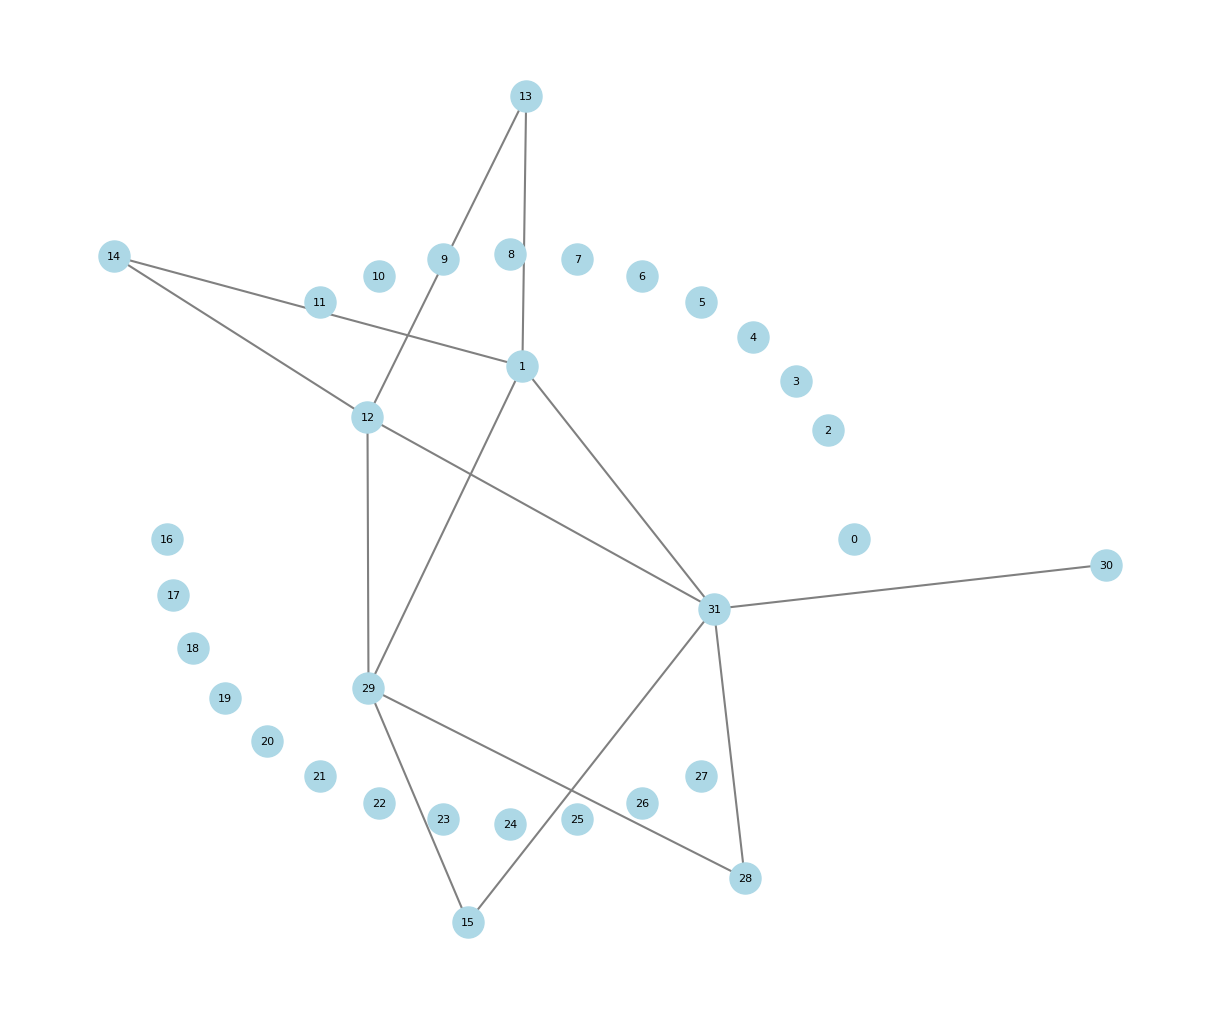

In [61]:
grafo = matriz_adyacencia_a_grafo_sin_diagonal(estado_sig)
dibujar_grafo(grafo)

In [62]:
from IPython.display import display
display(pd.DataFrame(estado_sig).style.set_properties(**{'text-align': 'center'}))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
latex_code = pd.DataFrame(estado_inicial).to_latex(
    caption="Matriz de estado inicial",
    label="tab:estado_inicial",
    position="h!",
    column_format="c"*len(estado_inicial),  # Centra todas las columnas
    escape=False  # Permite usar caracteres especiales
)